In [1]:
from pathlib import Path
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, FixedLocator

plt.style.use('fivethirtyeight')
# plt.style.available

In [10]:
RESULT_ROOT = Path('/home/yhuang2/PROJs/rtid/rtid/ae/inference/inference_speed_results')
MODELS = ('2d-4', '3d', '3d-fast')
MACHINES = ('A6000', 'H100', '6000ADA')
# A6000 and 6000ADA from sphenix, H100 from tara on a6k
GPU_ID_MAP = {'A6000': 0, '6000ADA': 2, 'H100': 0}

In [3]:
def format_x_axis(ax):
    ax.set_xscale('log', base=2)
    formatter = FuncFormatter(lambda x, _: f'{int(x)}')
    ax.xaxis.set_major_formatter(formatter)
    ticks = [2**i for i in range(8)]
    ax.xaxis.set_major_locator(FixedLocator(ticks))
    ax.set_xlabel('batch size')
    ax.set_ylabel('frames per second')
    ax.legend(prop={'family': 'monospace'})

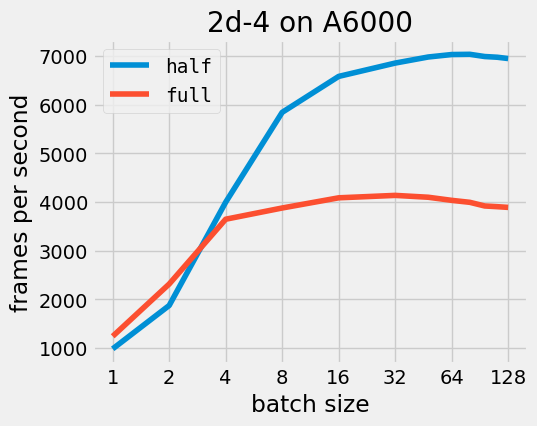

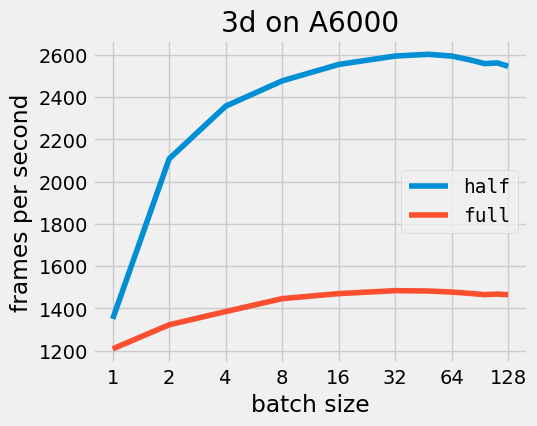

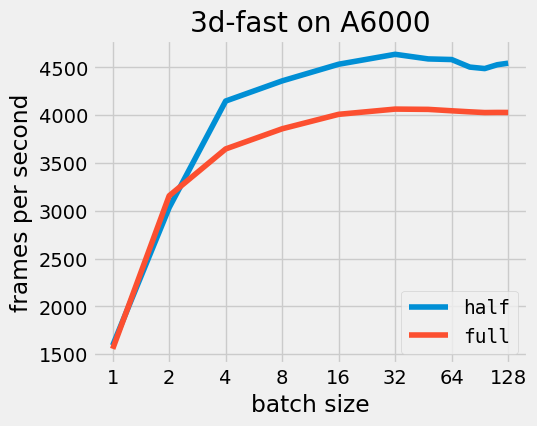

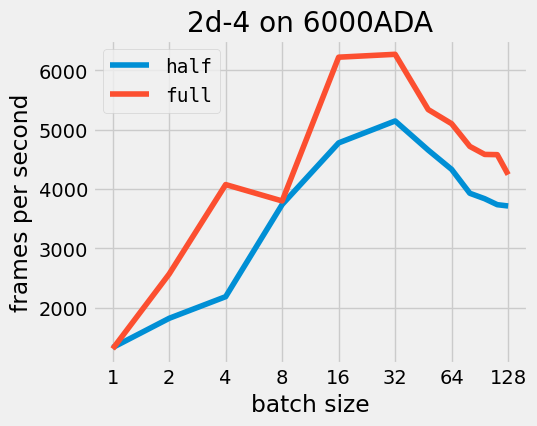

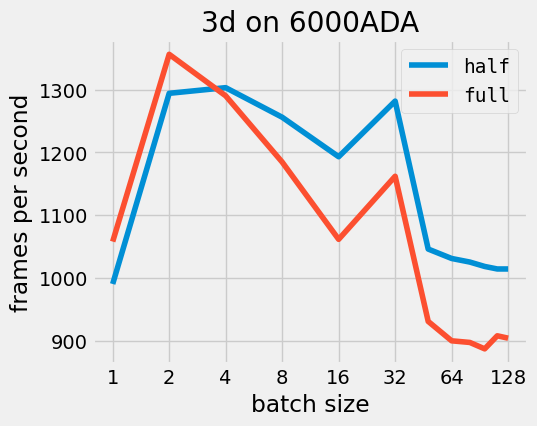

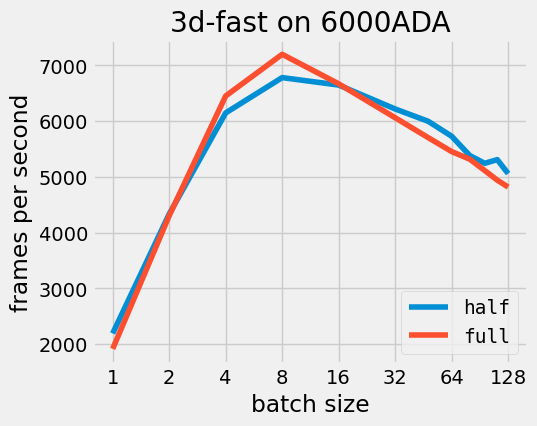

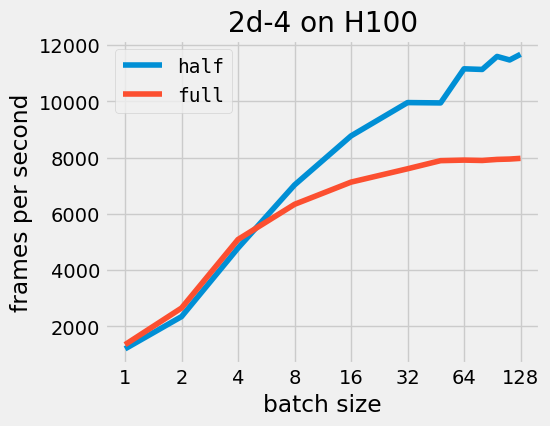

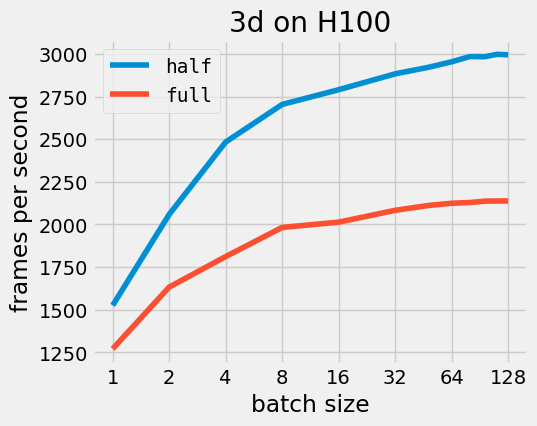

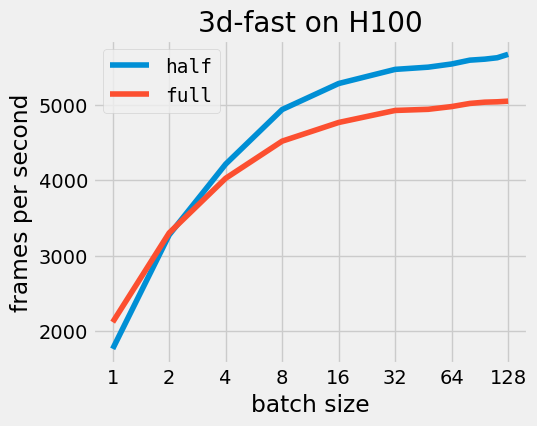

In [5]:
for machine in MACHINES:
    
    gpu_id = GPU_ID_MAP[machine]
    result_folder = RESULT_ROOT/f'inference_speed_{machine}/'
    
    for model in MODELS:
        fig, ax = plt.subplots(1, 1, figsize=(5, 4))
        for precision in ('half', 'full'):
            fname = result_folder/f'inference_speed_{gpu_id}_{model}_{precision}.csv'
            df = pd.read_csv(fname)
            
            df.plot(x='batch_size', y='frames_per_second', ax=ax, label=precision)
            format_x_axis(ax)
            ax.set_title(f'{model} on {machine}')
        fig.savefig(f'plots/{machine}_{model}.png', dpi=300, transparent=True, bbox_inches='tight')

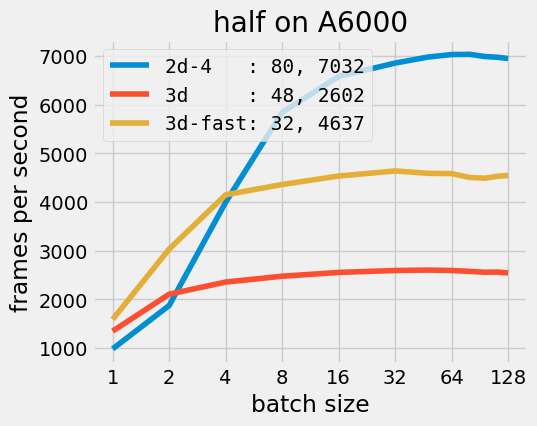

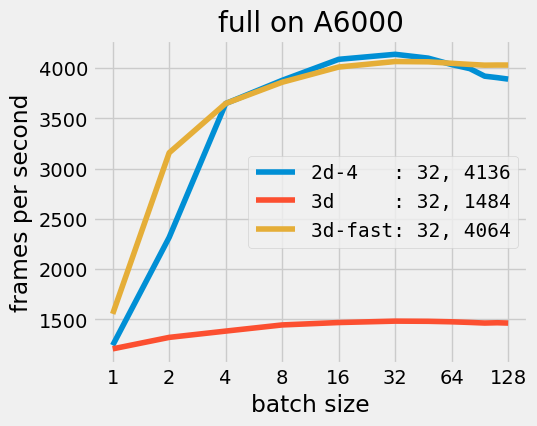

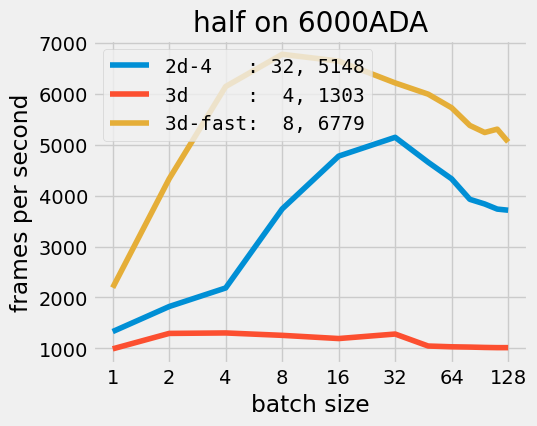

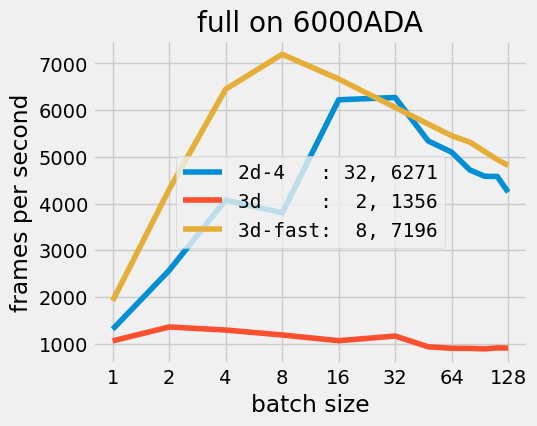

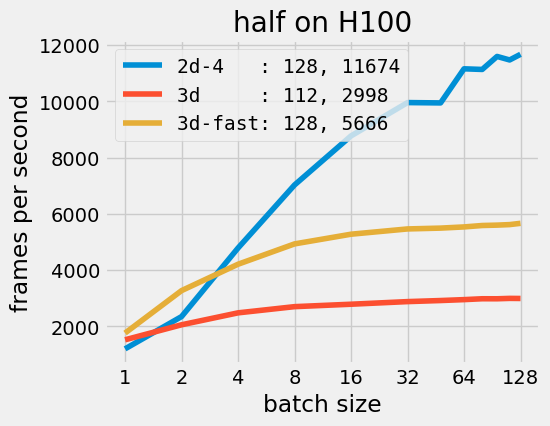

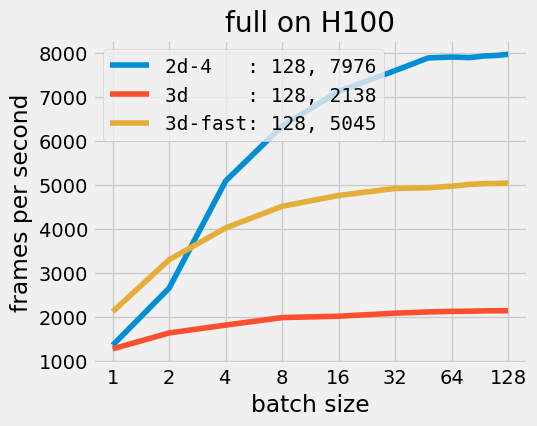

In [6]:
for machine in MACHINES:
    
    gpu_id = GPU_ID_MAP[machine]
    result_folder = RESULT_ROOT/f'inference_speed_{machine}/'
    
    for precision in ('half', 'full'):
        fig, ax = plt.subplots(1, 1, figsize=(5, 4))
        for model in MODELS:    
            fname = result_folder/f'inference_speed_{gpu_id}_{model}_{precision}.csv'
            df = pd.read_csv(fname)
    
            max_idx = df['frames_per_second'].idxmax()
            max_batch = int(df.iloc[max_idx]['batch_size'])
            max_throughput = df.iloc[max_idx]['frames_per_second']
    
            label = f'{model:7s}: {max_batch:2d}, {max_throughput:.0f}'
            df.plot(x='batch_size', y='frames_per_second', ax=ax, label=label)
            format_x_axis(ax)
            ax.set_title(f'{precision} on {machine}')
        fig.savefig(f'plots/{machine}_{precision}.png', dpi=300, transparent=True, bbox_inches='tight')

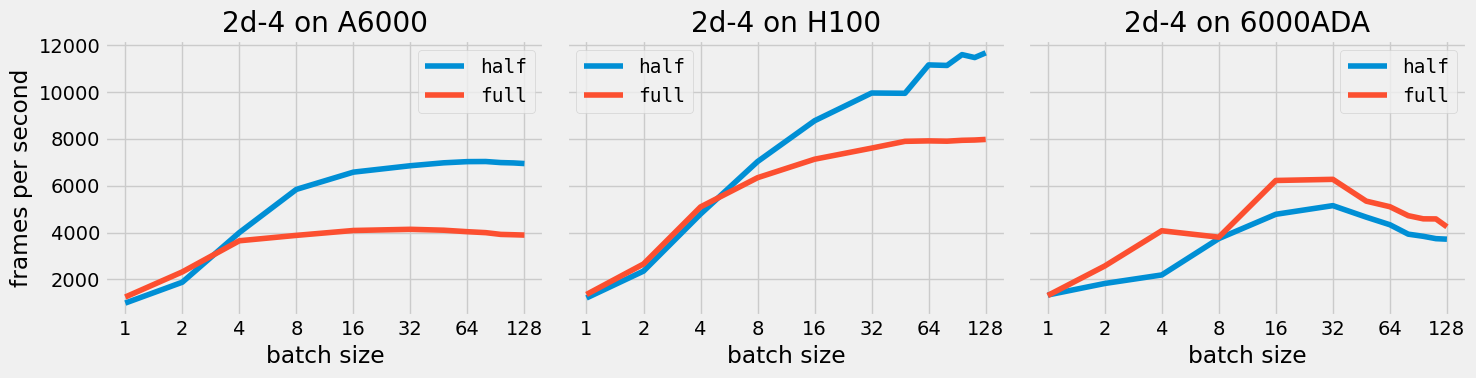

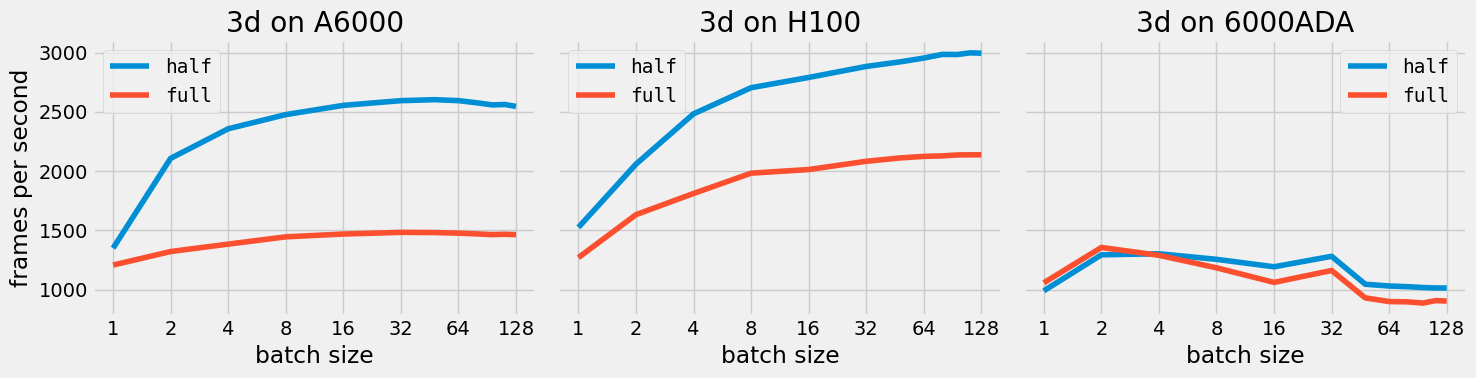

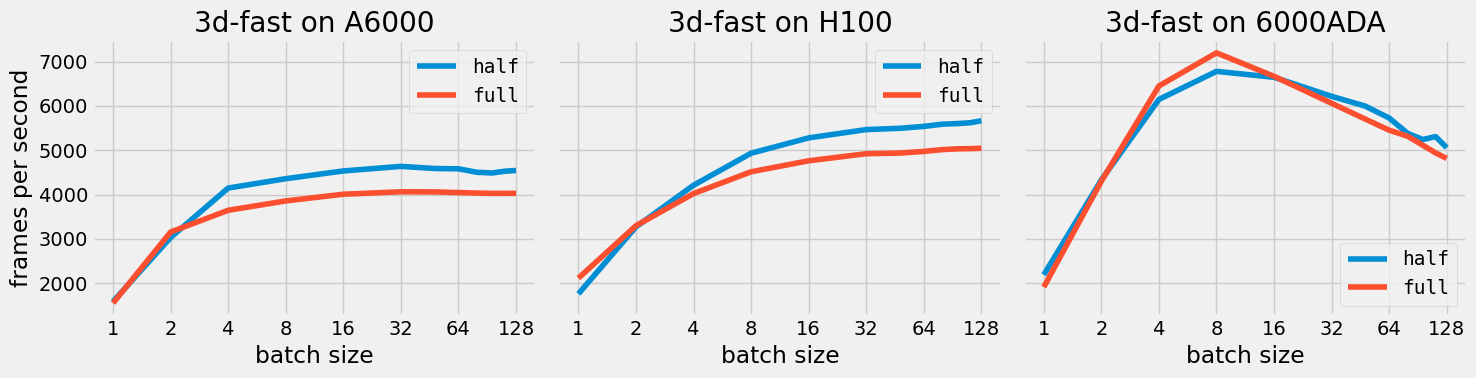

In [11]:
for model in MODELS:
    fig, axes = plt.subplots(1, len(MACHINES), 
                             figsize=(len(MACHINES) * 5, 4), 
                             sharey=True)
    for machine, ax in zip(MACHINES, axes):
        
        gpu_id = GPU_ID_MAP[machine]
        result_folder = RESULT_ROOT/f'inference_speed_{machine}/'
        
        for precision in ('half', 'full'):
            fname = result_folder/f'inference_speed_{gpu_id}_{model}_{precision}.csv'
            df = pd.read_csv(fname)
            
            df.plot(x='batch_size', y='frames_per_second', ax=ax, label=precision)
            format_x_axis(ax)
            ax.set_title(f'{model} on {machine}')
        
    fig.tight_layout()
    fig.savefig(f'plots/machine_comparison_{model}.png', dpi=600, transparent=True, bbox_inches='tight')

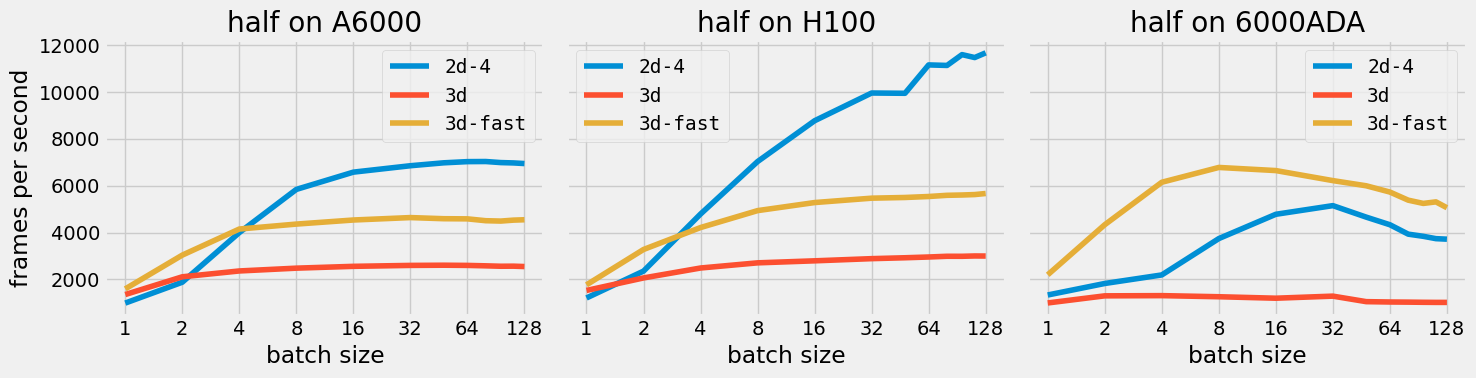

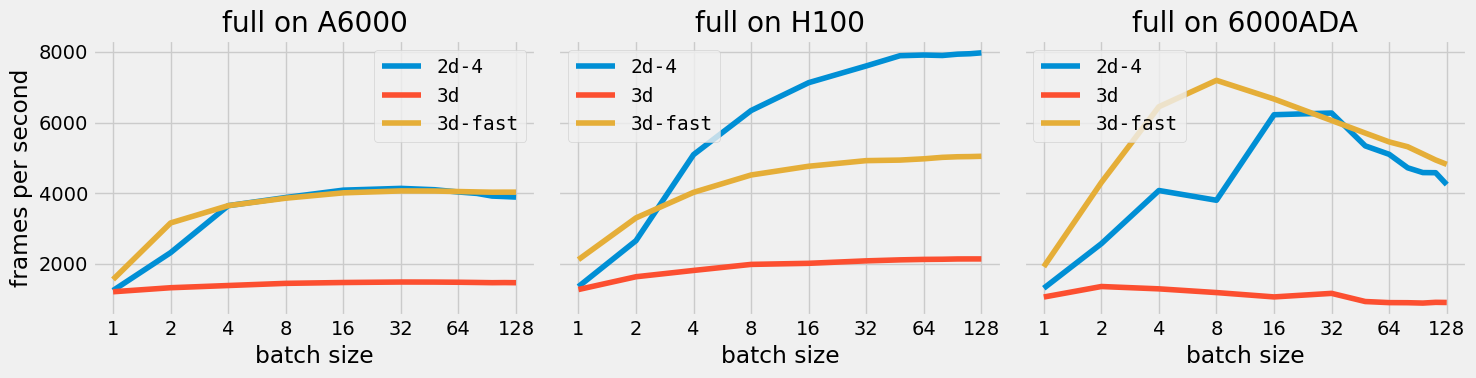

In [12]:
for precision in ('half', 'full'):
    fig, axes = plt.subplots(1, len(MACHINES), 
                             figsize=(len(MACHINES) * 5, 4), 
                             sharey=True)
    for machine, ax in zip(MACHINES, axes):
        
        gpu_id = GPU_ID_MAP[machine]
        result_folder = RESULT_ROOT/f'inference_speed_{machine}/'
        
        for model in MODELS:
            fname = result_folder/f'inference_speed_{gpu_id}_{model}_{precision}.csv'
            df = pd.read_csv(fname)
            
            df.plot(x='batch_size', y='frames_per_second', ax=ax, label=model)
            format_x_axis(ax)
            ax.set_title(f'{precision} on {machine}')
        
    fig.tight_layout()
    fig.savefig(f'plots/machine_comparison_{precision}.png', dpi=600, transparent=True, bbox_inches='tight')

## ME throughput

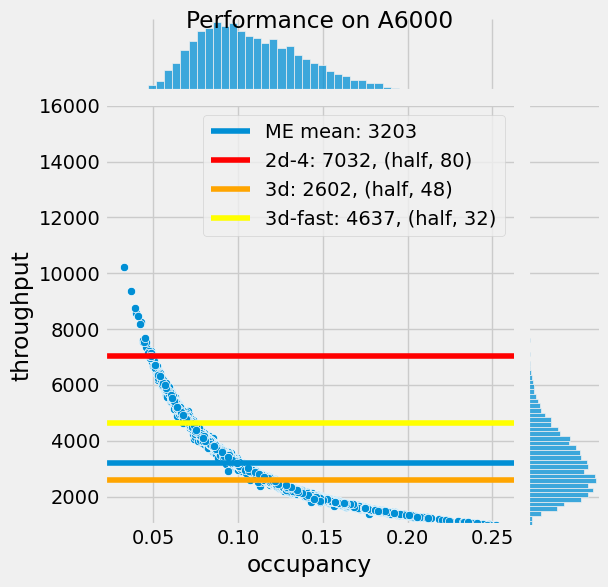

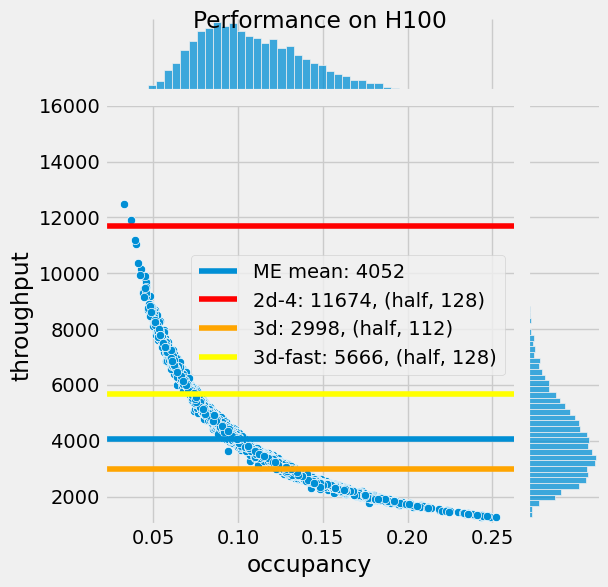

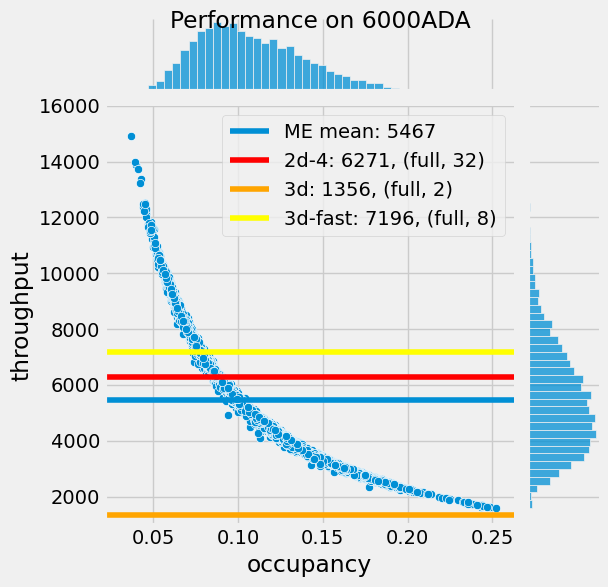

In [14]:
ME_RESULT_ROOT = Path('/home/yhuang2/PROJs/sparse_poi/inference/results/')
batch_size = 32
colors = ('red', 'orange', 'yellow')
for machine in MACHINES:

    # fig, ax = plt.subplots(1, 1)
    
    gpu_id = GPU_ID_MAP[machine]
    fname = ME_RESULT_ROOT/f'throughput_vs_occupancy-bs_{batch_size}-gpu_{machine}.csv'
    df = pd.read_csv(fname)
    mean = df.throughput.mean()
    joint_plot = sns.jointplot(x='occupancy', y='throughput', data=df)

    fig = joint_plot.fig
    ax = joint_plot.ax_joint

    ax.axhline(mean, label=f'ME mean: {mean:.0f}')

    # get peak dense performance
    for model, color in zip(MODELS, colors):
        result_folder = RESULT_ROOT/f'inference_speed_{machine}/'

        max_throughput = -1
        
        for precision in ('full', 'half'):
            fname = result_folder/f'inference_speed_{gpu_id}_{model}_{precision}.csv'
            df_dense = pd.read_csv(fname)
            
            max_idx = df_dense['frames_per_second'].idxmax()
            max_batch = int(df_dense.iloc[max_idx]['batch_size'])
            _max_throughput = df_dense.iloc[max_idx]['frames_per_second']

            if _max_throughput > max_throughput:
                max_throughput = _max_throughput
                dense_best = (precision, int(max_batch), max_throughput)
        
        ax.axhline(dense_best[-1], c=color, label=f'{model}: {max_throughput:.0f}, ({dense_best[0]}, {dense_best[1]})')
    ax.set_ylim(1000, 16000)
    ax.legend()
    fig.suptitle(f'Performance on {machine}')
    fig.savefig(f'plots/{machine}_me.png', dpi=600, bbox_inches='tight', transparent=True)